In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
data_path = "C:/Users/emily/Documents/DissertationProject/training/training_setA"
file_list = glob(os.path.join(data_path, "*.psv"))

df_list = [
    pd.read_csv(file, sep="|").assign(Patient_ID=i)  
    for i, file in enumerate(file_list)
]
hospitalA_df = pd.concat(df_list, ignore_index=True)
hospitalA_df = hospitalA_df.sort_values(by=["Patient_ID", "ICULOS"]).reset_index(drop=True)


In [2]:
#pickle
hospitalA_df.to_pickle("hospitalA_df_flat.pkl")

In [ ]:
import pandas as pd

hospitalA_df = pd.read_pickle("hospitalA_df_flat.pkl")

In [3]:
hospitalA_df.isna().sum()

HR                   61189
O2Sat                95079
Temp                523314
SBP                 120201
MAP                  80858
DBP                 380297
Resp                 77258
EtCO2               790215
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
Age                      0
Gender                   0
Unit1               386165
U

In [8]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

df = hospitalA_df.copy() 
target = "SepsisLabel"
features = [col for col in df.columns if col != target]  # Use all columns except target

df[features] = df.groupby("Patient_ID")[features].ffill().bfill()
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(eval_metric="logloss", max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC Score: {auc:.4f}")
#precision
#recall


Accuracy: 0.9947
AUC-ROC Score: 0.9985


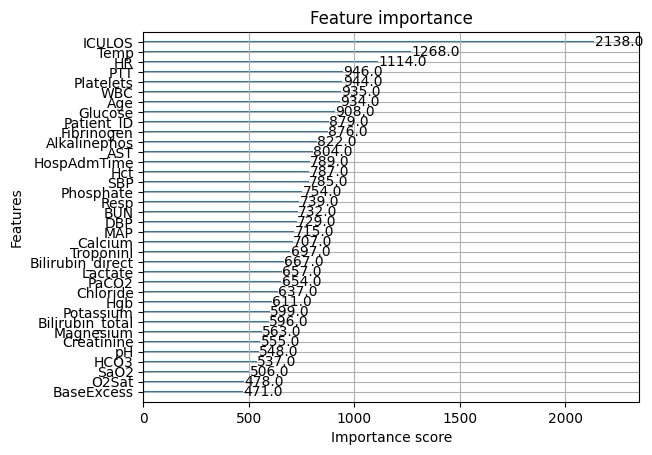

In [9]:
# Plot feature importance
xgb.plot_importance(model, importance_type="weight", max_num_features=36)
plt.show()

<Figure size 6000x4000 with 0 Axes>

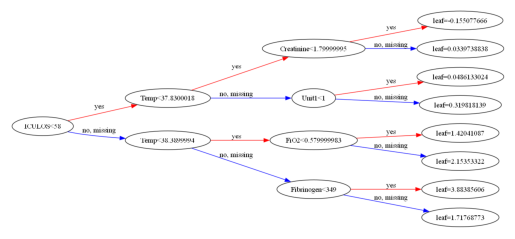

In [16]:
## plot decision tree
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Plot the first tree (index 0) using the new `tree_idx` parameter
plt.figure(figsize=(60, 40))
plot_tree(model, tree_idx=0, rankdir='LR')
plt.savefig("high_res_tree.png", dpi=1000)
plt.show()


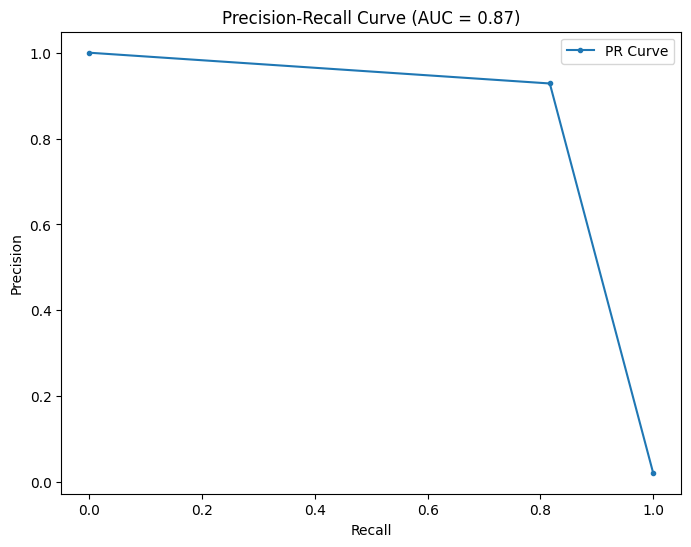

In [10]:
# precision recall curve
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# Calculate the area under the PR curve
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.legend()
plt.show()